Total number of samples in combined dataset: 84000


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/30], Train Acc: 41.66%, Val Acc: 62.87%
Epoch [2/30], Train Acc: 63.39%, Val Acc: 74.95%
Epoch [3/30], Train Acc: 71.62%, Val Acc: 79.05%
Epoch [4/30], Train Acc: 75.78%, Val Acc: 82.44%
Epoch [5/30], Train Acc: 78.50%, Val Acc: 84.18%
Epoch [6/30], Train Acc: 80.41%, Val Acc: 86.61%
Epoch [7/30], Train Acc: 82.42%, Val Acc: 87.59%
Epoch [8/30], Train Acc: 83.62%, Val Acc: 88.08%
Epoch [9/30], Train Acc: 84.18%, Val Acc: 89.24%
Epoch [10/30], Train Acc: 85.61%, Val Acc: 89.35%
Epoch [11/30], Train Acc: 86.46%, Val Acc: 90.07%
Epoch [12/30], Train Acc: 86.72%, Val Acc: 90.60%
Epoch [13/30], Train Acc: 87.74%, Val Acc: 90.85%
Epoch [14/30], Train Acc: 88.14%, Val Acc: 91.02%
Epoch [15/30], Train Acc: 88.59%, Val Acc: 90.68%
Epoch [16/30], Train Acc: 89.67%, Val Acc: 91.58%
Epoch [17/30], Train Acc: 89.55%, Val Acc: 91.74%
Epoch [18/30], Train Acc: 89.88%, Val Acc: 92.12%
Epoch [19/30], Train Acc: 89.99%, Val Acc: 91.54%
Epoch [20/30], Train Acc: 90.55%, Val Acc: 92.39%
Epoch [21

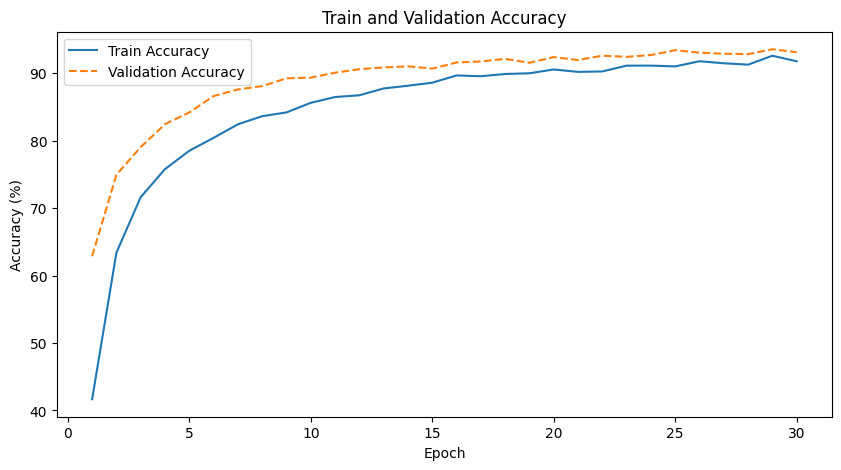

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchvision import transforms, datasets, models
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. 데이터 전처리 설정
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

augment1 = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

augment2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

# 3. 데이터셋 로드
trainset_path = "C:/Users/USER/Desktop/Semester2/train_data"
user_dataset = datasets.ImageFolder(root=trainset_path, transform=basic_transform)

cifar10 = datasets.CIFAR10(root="C:/Users/USER/Desktop/Semester2/CIFAR10", train=True, download=False, transform=basic_transform)
cifar10_dataset1 = datasets.CIFAR10(root="C:/Users/USER/Desktop/Semester2/CIFAR10", train=True, download=False, transform=augment1)
cifar10_dataset2 = datasets.CIFAR10(root="C:/Users/USER/Desktop/Semester2/CIFAR10", train=True, download=False, transform=augment2)

# 4. 랜덤하게 10,000장씩 선택
num_samples = 15000
indices1 = np.random.choice(len(cifar10_dataset1), num_samples, replace=False)
indices2 = np.random.choice(len(cifar10_dataset2), num_samples, replace=False)
cifar10_dataset1 = Subset(cifar10_dataset1, indices1)
cifar10_dataset2 = Subset(cifar10_dataset2, indices2)

# 5. 데이터셋 결합
combined_dataset = ConcatDataset([user_dataset, cifar10, cifar10_dataset1, cifar10_dataset2])
combined_labels = np.concatenate((np.array([label for _, label in user_dataset.samples]),
                                  np.array(cifar10.targets),
                                  np.array(cifar10.targets)[indices1],
                                  np.array(cifar10.targets)[indices2]))

print(f"Total number of samples in combined dataset: {len(combined_dataset)}")

# 6. 데이터셋을 학습 및 검증 세트로 나누기 (Stratified Split)
train_idx, val_idx = train_test_split(
    np.arange(len(combined_labels)),
    test_size=0.2,  # 전체 데이터의 20%를 검증 데이터로 사용
    stratify=combined_labels,  # 각 클래스의 비율을 유지하며 분할
    random_state=42
)

train_subset = Subset(combined_dataset, train_idx) 
val_subset = Subset(combined_dataset, val_idx)
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

# 7. CutMix를 적용하는 함수
def cutmix_data(input, target, beta=1.0):
    lam = np.random.beta(beta, beta)
    rand_index = torch.randperm(input.size()[0]).to(device)
    target_a = target
    target_b = target[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam)
    input[:, :, bbx1:bbx2, bby1:bby2] = input[rand_index, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size(-1) * input.size(-2)))
    return input, target_a, target_b, lam

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

# 8. 모델 학습 및 검증
num_epochs = 30
cutmix_prob = 0.15
learning_rate = 0.001  # 고정 학습률
train_accuracies, val_accuracies = [], []

# 모델 설정
model = models.efficientnet_b0(pretrained=False)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    correct_train, total_train = 0, 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # CutMix 적용 여부 결정
        r = np.random.rand(1)
        if r < cutmix_prob:
            inputs, target_a, target_b, lam = cutmix_data(inputs, targets)
            outputs = model(inputs)
            loss = lam * criterion(outputs, target_a) + (1 - lam) * criterion(outputs, target_b)
        else:
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = outputs.max(1)
        correct_train += preds.eq(targets).sum().item()
        total_train += targets.size(0)

    train_acc = 100 * correct_train / total_train
    train_accuracies.append(train_acc)

    # 검증
    model.eval()
    correct_val, total_val = 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            correct_val += preds.eq(targets).sum().item()
            total_val += targets.size(0)

    val_acc = 100 * correct_val / total_val
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

# 9. 학습 및 검증 정확도 시각화
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()


In [5]:
torch.save(model.state_dict(), 'C:/Users/USER/Desktop/Semester2/te.pth')